In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [3]:
data = pd.read_csv('cleaned_short.csv')

In [4]:
with timer('CountVect'):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
    doc_word = vectorizer.fit_transform(data.comment_text)

[CountVect] start.
[CountVect] done in 0.80 min.


In [5]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
with timer('SVD'):
    lsa = TruncatedSVD(30)
    doc_topic = lsa.fit_transform(doc_word)

[SVD] start.
[SVD] done in 2.28 min.


In [6]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [7]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
people, just, like, did, trump, women, does, think, church, know

Topic  1
people, trump, white, black, president, like, obama, racist, white people, country

Topic  2
trump, women, did, men, president, just, like, obama, clinton, hillary

Topic  3
women, men, people, woman, men women, male, children, white, rights, sexual

Topic  4
trump, church, people, women, men, catholic, god, white, catholic church, president

Topic  5
god, did, jesus, love, man, know, said, women, people, men

Topic  6
white, black, did, church, racist, racism, right, white people, race, man

Topic  7
did, church, people, years, catholic, time, state, know, government, think

Topic  8
like, did, church, white, people, women, jesus, men, people like, just like

Topic  9
just, did, church, people, trump, women, god, white, men, just like

Topic  10
think, know, time, good, years, really, way, going, white, better

Topic  11
does, think, know, say, did, mean, make, does mean, does make, really

Topic  12


In [8]:
def components(n):
    return ['component_{0}'.format(s) for s in range(1, n+1)]

In [9]:
doc_topic = pd.DataFrame(doc_topic.round(5), index=data.comment_text, columns=components(30))

In [10]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [11]:
y = np.where(data['target'] >= 0.5, 1, 0)

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(doc_topic, y, test_size=0.3, random_state=42)
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)
x_balance = pd.DataFrame(x_balance, columns=x_train.columns)

In [13]:
lr.fit(x_balance, y_balance)
y_pred = lr.predict(x_test)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

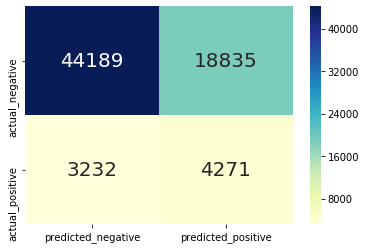

In [15]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred)

In [16]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg']
results

,LogReg
Accuracy,0.687
Precision,0.185
Recall,0.569
F1 Score,0.279


In [17]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_balance, y_balance)
y_pred_nb = bnb.predict(x_test)

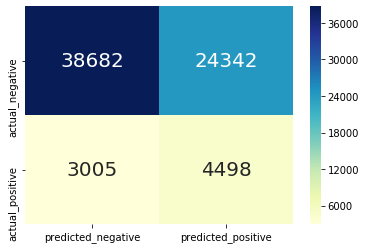

In [18]:
# Here's the heat map for the first Naive Bayes model
cm2 = conf_matrix(y_test, y_pred_nb)

In [19]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1, cm2)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec']
results

,LogReg_CountVec,NB_CountVec
Accuracy,0.687,0.612
Precision,0.185,0.156
Recall,0.569,0.599
F1 Score,0.279,0.248


[timer] start.


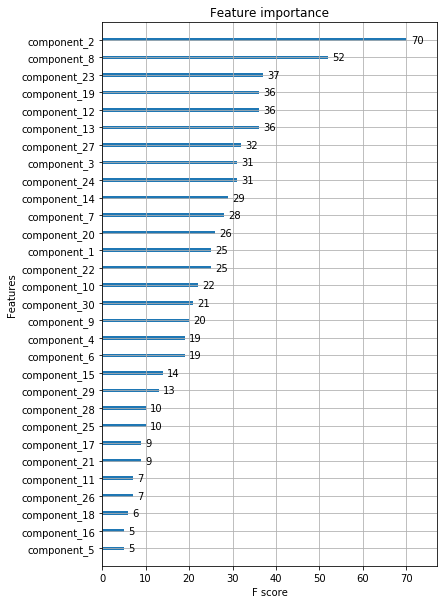

ROC_AUC:  0.64584977128722
[[43172 19852]
 [ 2951  4552]]
[timer] done in 2.12 min.


In [20]:
with timer('timer'):
    model = XGBClassifier()
    model.fit(x_balance, y_balance)
    # plot feature importance
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(6, 10)
    pyplot.show()
    predict = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    print("ROC_AUC: ", roc_auc)
    print(confusion_matrix(y_test, predict))

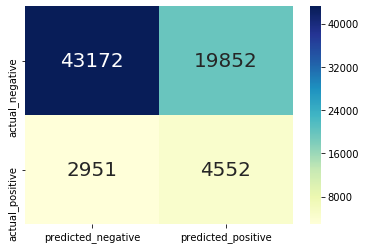

In [21]:
cm3 = conf_matrix(y_test, predict)

In [22]:
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.687,0.612,0.677
Precision,0.185,0.156,0.187
Recall,0.569,0.599,0.607
F1 Score,0.279,0.248,0.286


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

In [6]:
import pandas as pd
import numpy as np
import nltk
import pickle
from contextlib import contextmanager
import copy
import os
import re
import string
import time
import warnings
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
# Create a function to calculate the error metrics, since we'll be doing this several times
def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    
    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
        
    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

In [7]:
@contextmanager
def timer(msg):
    t0 = time.time()
    print(f'[{msg}] start.')
    yield
    elapsed_time = time.time() - t0
    print(f'[{msg}] done in {elapsed_time / 60:.2f} min.')

In [9]:
data = pd.read_csv('cleaned_short_simple.csv')

In [23]:
any(data.comment_text.isnull())

True

In [28]:
data.comment_text = data.comment_text.replace(np.nan, '')

In [118]:
with timer('CountVect'):
    vectorizer = CountVectorizer(stop_words='english')
    doc_word = vectorizer.fit_transform(data.comment_text)

[CountVect] start.
[CountVect] done in 0.16 min.


In [149]:
# Acronynms: Latent Semantic Analysis (LSA) is just another name for 
#  Signular Value Decomposition (SVD) applied to Natural Language Processing (NLP)
with timer('SVD'):
    lsa = TruncatedSVD(50)
    doc_topic = lsa.fit_transform(doc_word)

[SVD] start.
[SVD] done in 0.21 min.


In [150]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [151]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
people, like, trump, women, think, church, know, white, right, god

Topic  1
trump, people, white, black, president, obama, like, racist, country, racism

Topic  2
trump, women, men, like, president, obama, clinton, hillary, right, said

Topic  3
women, men, people, woman, male, children, white, rights, want, female

Topic  4
trump, people, church, women, men, catholic, god, donald, clinton, president

Topic  5
god, jesus, love, trump, man, people, life, know, women, said

Topic  6
white, black, god, racist, man, racism, men, jesus, race, right

Topic  7
like, white, god, church, women, trump, men, people, black, jesus

Topic  8
think, know, really, white, black, say, good, maybe, agree, way

Topic  9
right, think, left, wing, rights, like, alt, wrong, abortion, speech

Topic  10
know, right, say, man, said, woman, catholic, let, read, truth

Topic  11
state, know, tax, god, government, pay, money, white, think, taxes

Topic  12
law, catholic, muslim, say, muslims, jesus, sai

In [152]:
def components(n):
    return ['component_{0}'.format(s) for s in range(1, n+1)]

In [153]:
doc_topic = pd.DataFrame(doc_topic, index=data.comment_text, columns=components(50))

## Modeling

In [154]:
# Create a logistic regression model to use
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [155]:
y = data.y

In [156]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(doc_topic, y, test_size=0.25, random_state=42)
x_balance, y_balance = RandomOverSampler().fit_sample(x_train, y_train)
x_balance = pd.DataFrame(x_balance, columns=x_train.columns)

In [157]:
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

/Users/kelvin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


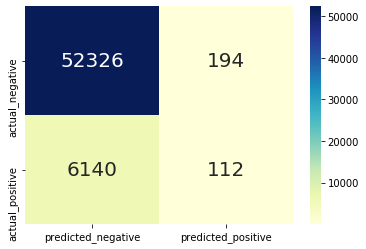

In [158]:
# The heat map for the first logistic regression model
cm1 = conf_matrix(y_test, y_pred)

In [159]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
y_pred_nb = bnb.predict(x_test)

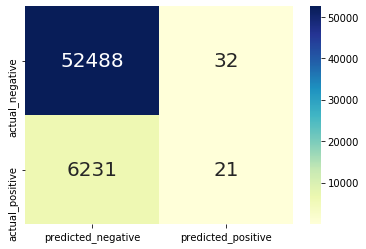

In [160]:
# Here's the heat map for the first Naive Bayes model
cm2 = conf_matrix(y_test, y_pred_nb)

[timer] start.


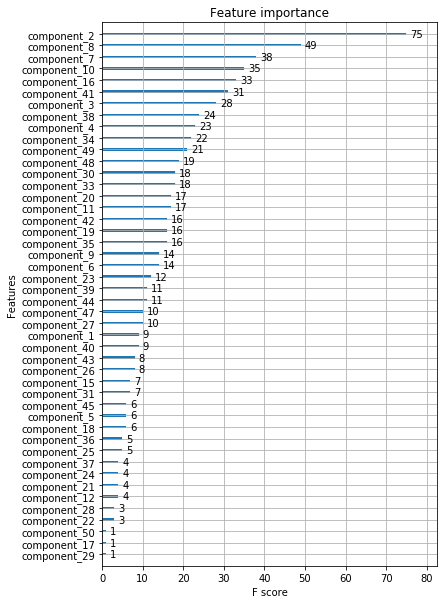

[timer] done in 1.92 min.


In [161]:
with timer('timer'):
    model = XGBClassifier()
    model.fit(x_train, y_train)
    # plot feature importance
    ax = plot_importance(model)
    fig = ax.figure
    fig.set_size_inches(6, 10)
    pyplot.show()
    predict = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predict)

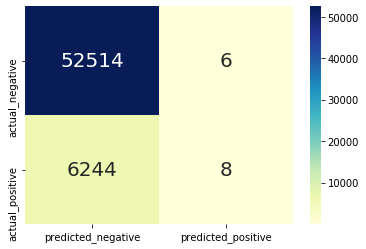

In [162]:
cm3 = conf_matrix(y_test, predict)

In [63]:
# 50 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.701,0.632,0.691
Precision,0.193,0.164,0.195
Recall,0.572,0.602,0.611
F1 Score,0.289,0.258,0.296


In [78]:
# 40 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.688,0.626,0.680
Precision,0.188,0.161,0.190
Recall,0.583,0.597,0.614
F1 Score,0.284,0.254,0.290


In [48]:
# 30 topic Oversample
results = pd.DataFrame(list(zip(cm1, cm2, cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg_CountVec', 'NB_CountVec', 'XBG_CountVec']
results

,LogReg_CountVec,NB_CountVec,XBG_CountVec
Accuracy,0.686,0.622,0.679
Precision,0.184,0.159,0.188
Recall,0.567,0.592,0.607
F1 Score,0.278,0.251,0.287
